### d2 + d3 reconstruction

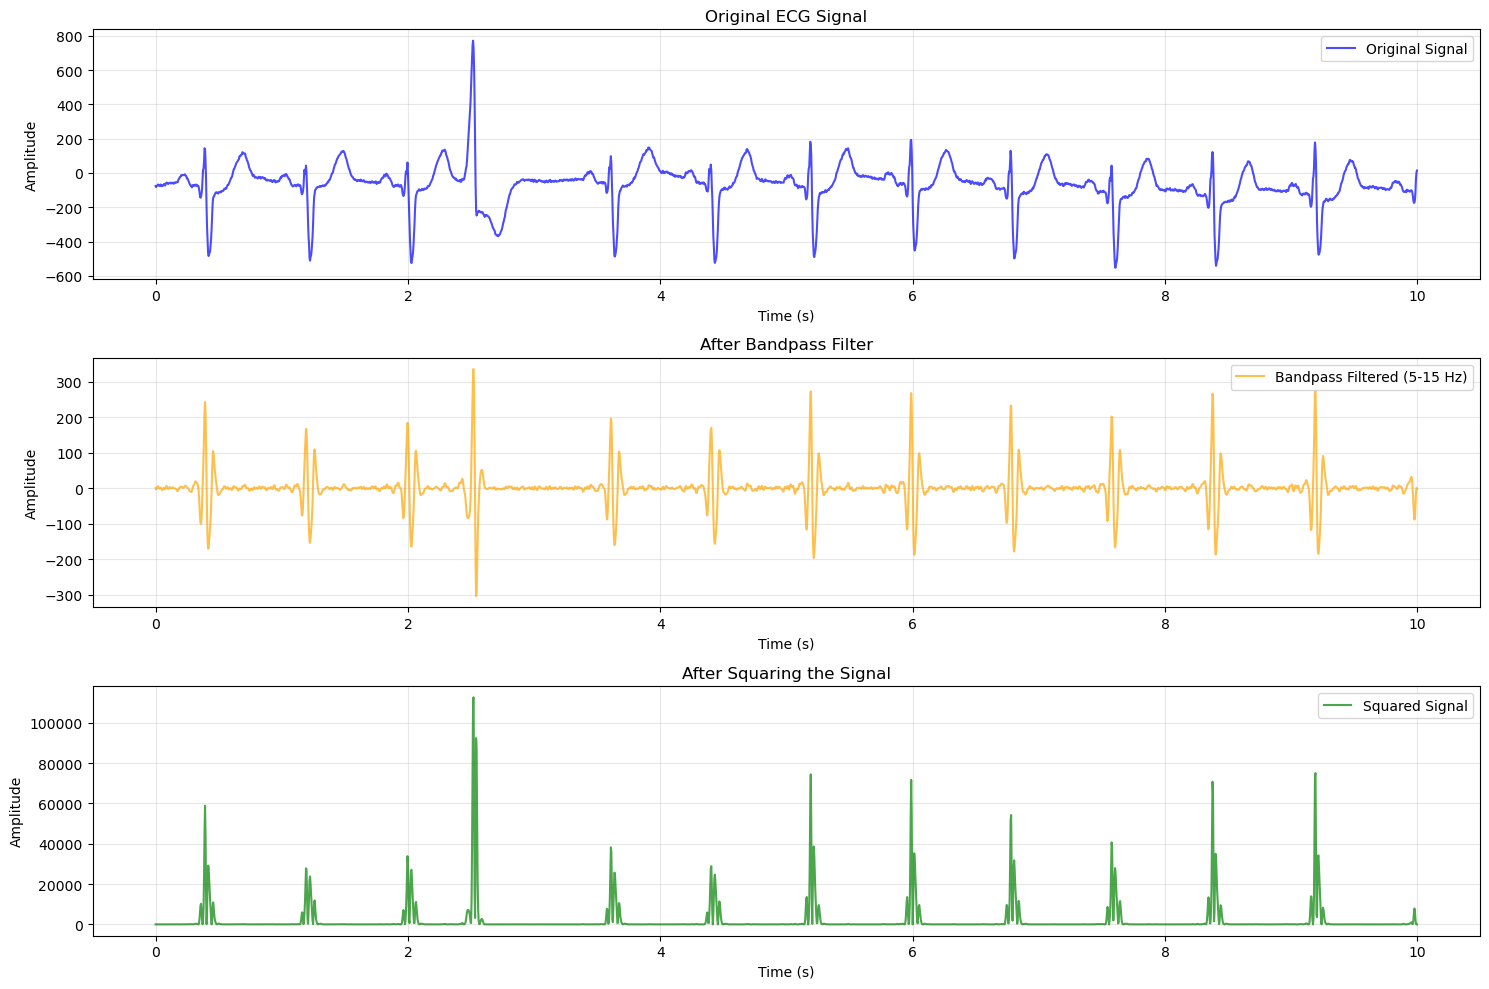

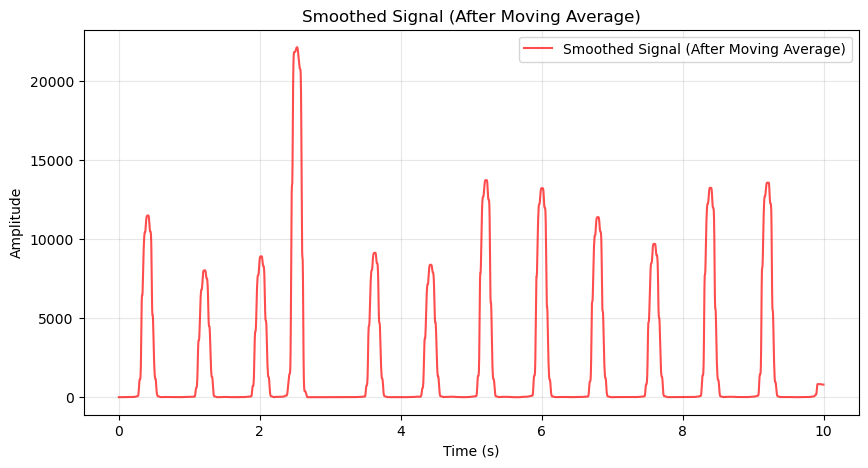

In [1]:
import numpy as np
import pywt
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

def preprocess_signal_with_plot(signal, fs):
    """Preprocess the signal and plot intermediate steps."""
    nyquist = fs / 2
    low = 10 / nyquist
    high = 50 / nyquist

    # Bandpass filter (5-15 Hz)
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)

    # Square the signal
    squared = filtered ** 2

    # Moving average for smoothing
    window_size = int(0.15 * fs)  # 150ms window
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(squared, kernel, mode='same')

    # Plot each preprocessing step
    plt.figure(figsize=(15, 10))
    time = np.arange(len(signal)) / fs  # Convert samples to seconds

    # Original signal
    plt.subplot(311)
    plt.plot(time, signal, label='Original Signal', color='blue', alpha=0.7)
    plt.title('Original ECG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # After bandpass filtering
    plt.subplot(312)
    plt.plot(time, filtered, label='Bandpass Filtered (5-15 Hz)', color='orange', alpha=0.7)
    plt.title('After Bandpass Filter')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # After squaring the signal
    plt.subplot(313)
    plt.plot(time, squared, label='Squared Signal', color='green', alpha=0.7)
    plt.title('After Squaring the Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return filtered, squared, smoothed

def main():
    # Load ECG data from a .mat file
    mat_data = loadmat('08378m.mat')
    fs = 250  # Sampling frequency (Hz)
    ecg_signal = mat_data['val'][0].squeeze()  # Extract the ECG signal

    # Preprocess the signal and plot intermediate steps
    filtered, squared, smoothed = preprocess_signal_with_plot(ecg_signal, fs)

    # Plot final smoothed signal
    plt.figure(figsize=(10, 5))
    time = np.arange(len(smoothed)) / fs
    plt.plot(time, smoothed, label='Smoothed Signal (After Moving Average)', color='red', alpha=0.7)
    plt.title('Smoothed Signal (After Moving Average)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


### db6

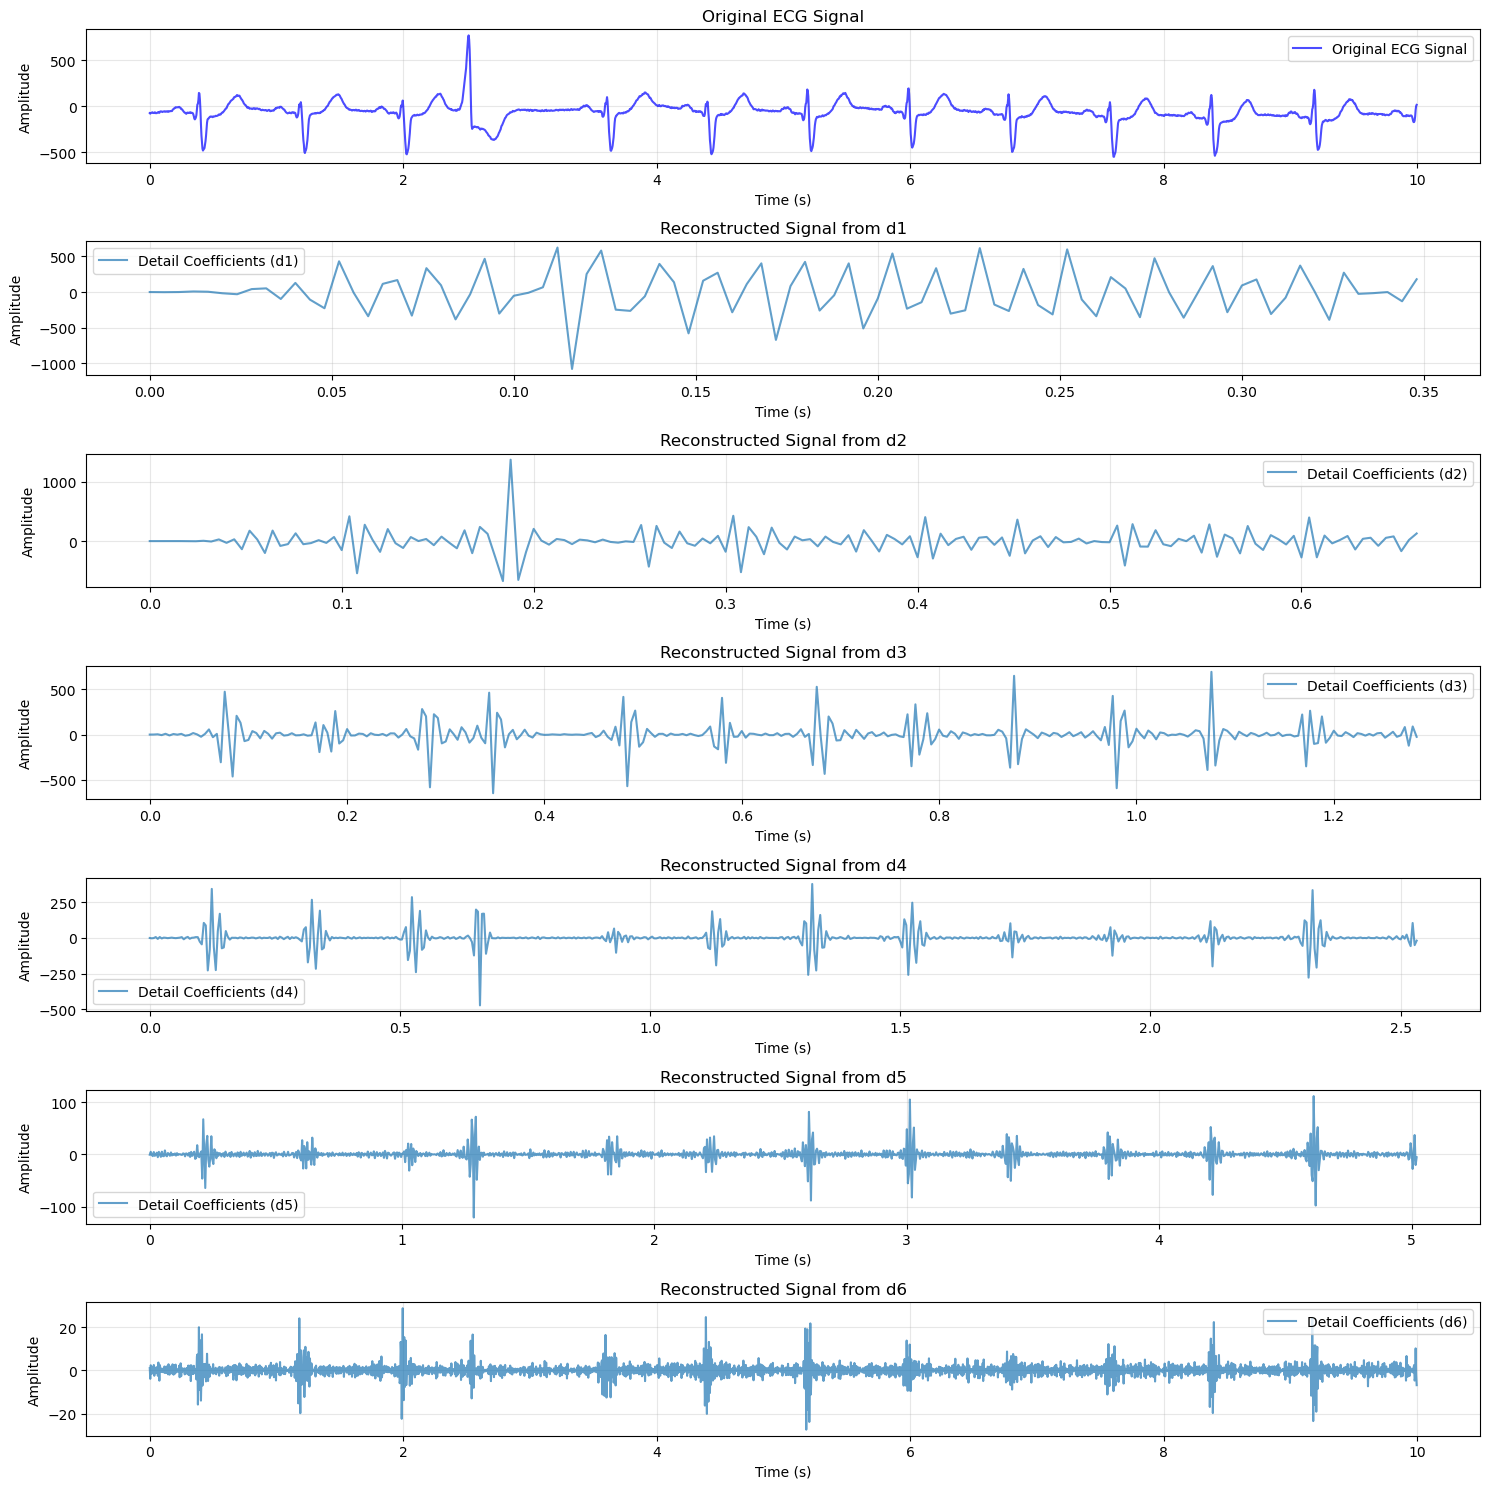

In [3]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import loadmat

def plot_wavelet_details(signal, wavelet='db6', levels=6):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=levels)

    # Reconstruct signals for each detail level (d1 to d6)
    reconstructed_details = [pywt.idwt(None, coeff, wavelet) for coeff in coeffs[1:]]

    # Create time vector
    fs = 250  # Sampling frequency (Hz)
    time = np.arange(len(signal)) / fs  # Convert samples to seconds

    # Plot original signal and detail components
    plt.figure(figsize=(15, 15))

    # Plot original signal
    plt.subplot(levels + 1, 1, 1)
    plt.plot(time, signal, label='Original ECG Signal', color='blue', alpha=0.7)
    plt.title('Original ECG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot detail coefficients (d1 to d6)
    for i, detail in enumerate(reconstructed_details, start=1):
        plt.subplot(levels + 1, 1, i + 1)
        plt.plot(time[:len(detail)], detail, label=f'Detail Coefficients (d{i})', alpha=0.7)
        plt.title(f'Reconstructed Signal from d{i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load ECG data from a .mat file
    mat_data = loadmat('08378m.mat')
    fs = 250  # Sampling frequency (Hz)
    ecg_signal = mat_data['val'][0].squeeze()  # Extract the ECG signal

    # Plot wavelet details
    plot_wavelet_details(ecg_signal)

if __name__ == '__main__':
    main()


### sym4

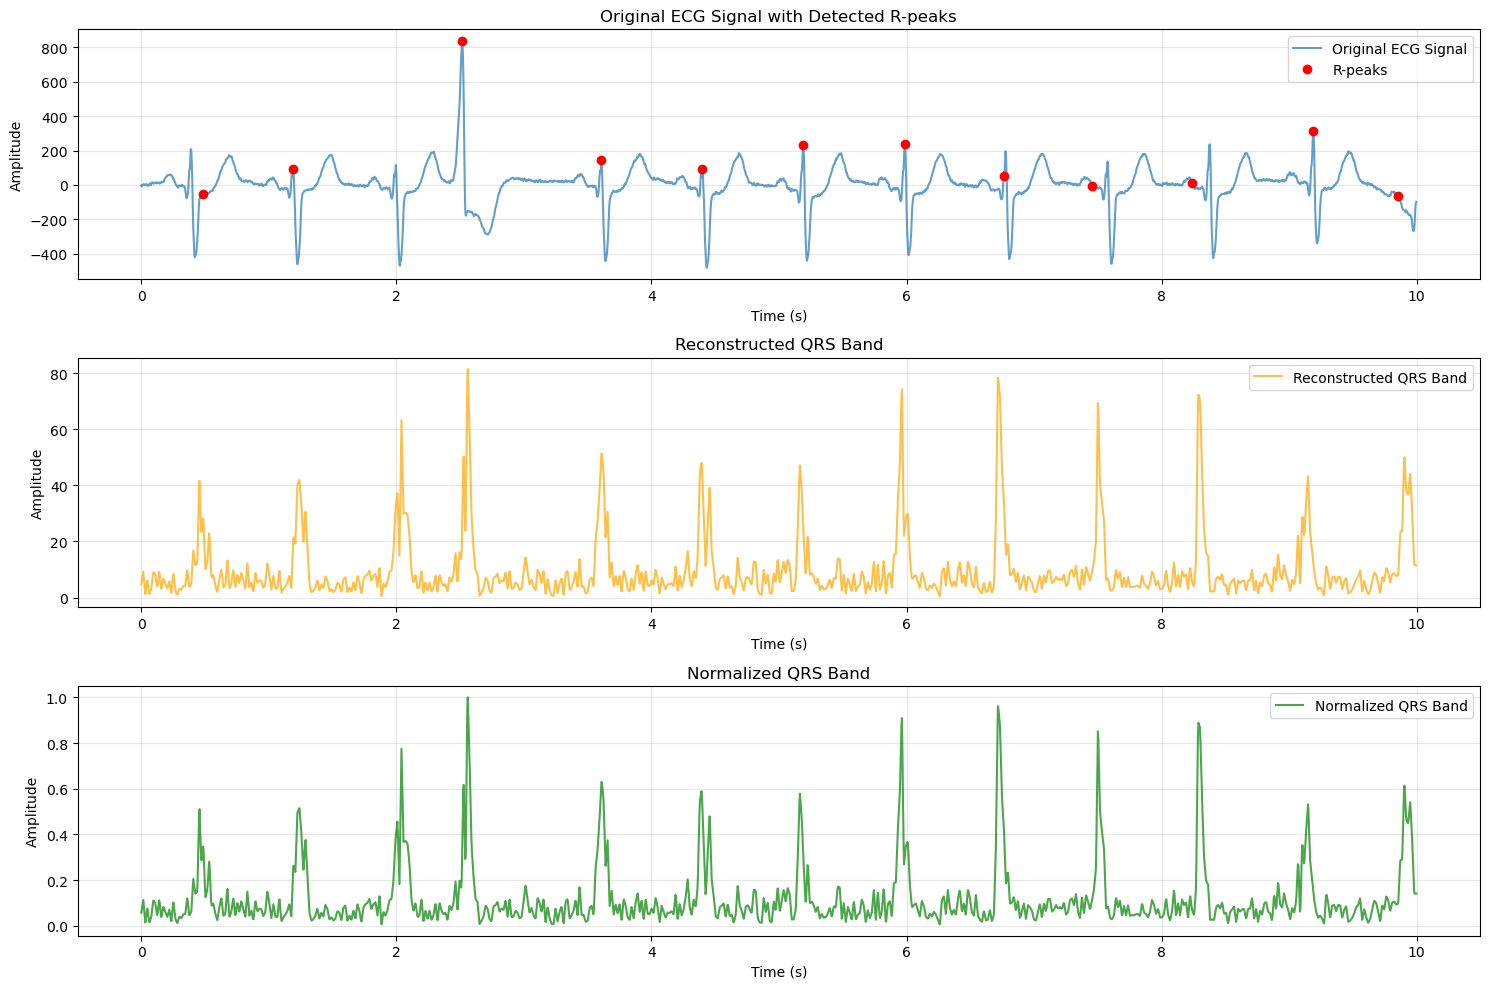

Detected R-peaks at indices: [ 121  298  629  902 1100 1297 1497 1690 1863 2060 2297 2464]


In [59]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import loadmat

def preprocess_signal(signal, fs):
    """High-pass filter to remove baseline wander."""
    nyquist = fs / 2
    low = 0.5 / nyquist  # Cutoff frequency: 0.5 Hz
    b, a = butter(2, low, btype='high')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def detect_r_peaks(signal, wavelet='coif3', level=3, fs=250):   #sym4
    """Detect precise R-peaks using wavelet decomposition and refinement."""
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Combine detail coefficients d2 and d3
    d2 = coeffs[2]
    d3 = coeffs[3]
    d3_upsampled = np.interp(np.linspace(0, len(d3), len(d2)),
                             np.arange(len(d3)),
                             d3)
    qrs_band = np.abs(d2) + np.abs(d3_upsampled)

    # Reconstruct signal from QRS band
    reconstructed_signal = np.interp(np.linspace(0, len(qrs_band), len(signal)),
                                      np.arange(len(qrs_band)),
                                      qrs_band)
    
    # Normalize the reconstructed signal
    normalized_signal = reconstructed_signal / np.max(reconstructed_signal)
    
    # Detect peaks in the normalized QRS band
    min_rr = int(0.6 * fs)  # Minimum R-R interval (600ms)
    min_height = 0.3        # Minimum peak height
    peaks, _ = find_peaks(normalized_signal, height=min_height, distance=min_rr)

    # Refine peaks to locate precise R positions
    refined_peaks = []
    search_window = int(0.05 * fs)  # +/-50ms window for refinement
    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(signal), peak + search_window)
        refined_peak = start + np.argmax(signal[start:end])
        refined_peaks.append(refined_peak)

    return np.array(refined_peaks), reconstructed_signal, normalized_signal

def plot_r_peaks(original_signal, reconstructed_signal, normalized_signal, r_peaks, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 10))

    # Original ECG Signal with R-peaks
    plt.subplot(311)
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    plt.title('Original ECG Signal with Detected R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Reconstructed QRS band
    plt.subplot(312)
    plt.plot(time, reconstructed_signal, label='Reconstructed QRS Band', color='orange', alpha=0.7)
    plt.title('Reconstructed QRS Band')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Normalized QRS Band
    plt.subplot(313)
    plt.plot(time, normalized_signal, label='Normalized QRS Band', color='green', alpha=0.7)
    plt.title('Normalized QRS Band')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    # Load ECG data from a .mat file
    mat_data = loadmat('08378m.mat')
    #mat_data = loadmat('s0017lrem.mat')
    fs = 250  # Sampling frequency
    ecg_signal = mat_data['val'][0].squeeze()

    # Preprocess signal
    filtered_signal = preprocess_signal(ecg_signal, fs)
    r_peaks, reconstructed_signal, normalized_signal = detect_r_peaks(filtered_signal, fs=fs)

    # Plot results
    plot_r_peaks(filtered_signal, reconstructed_signal, normalized_signal, r_peaks, fs)

    print("Detected R-peaks at indices:", r_peaks)

if __name__ == '__main__':
    main()


### squaring and filtering the signal

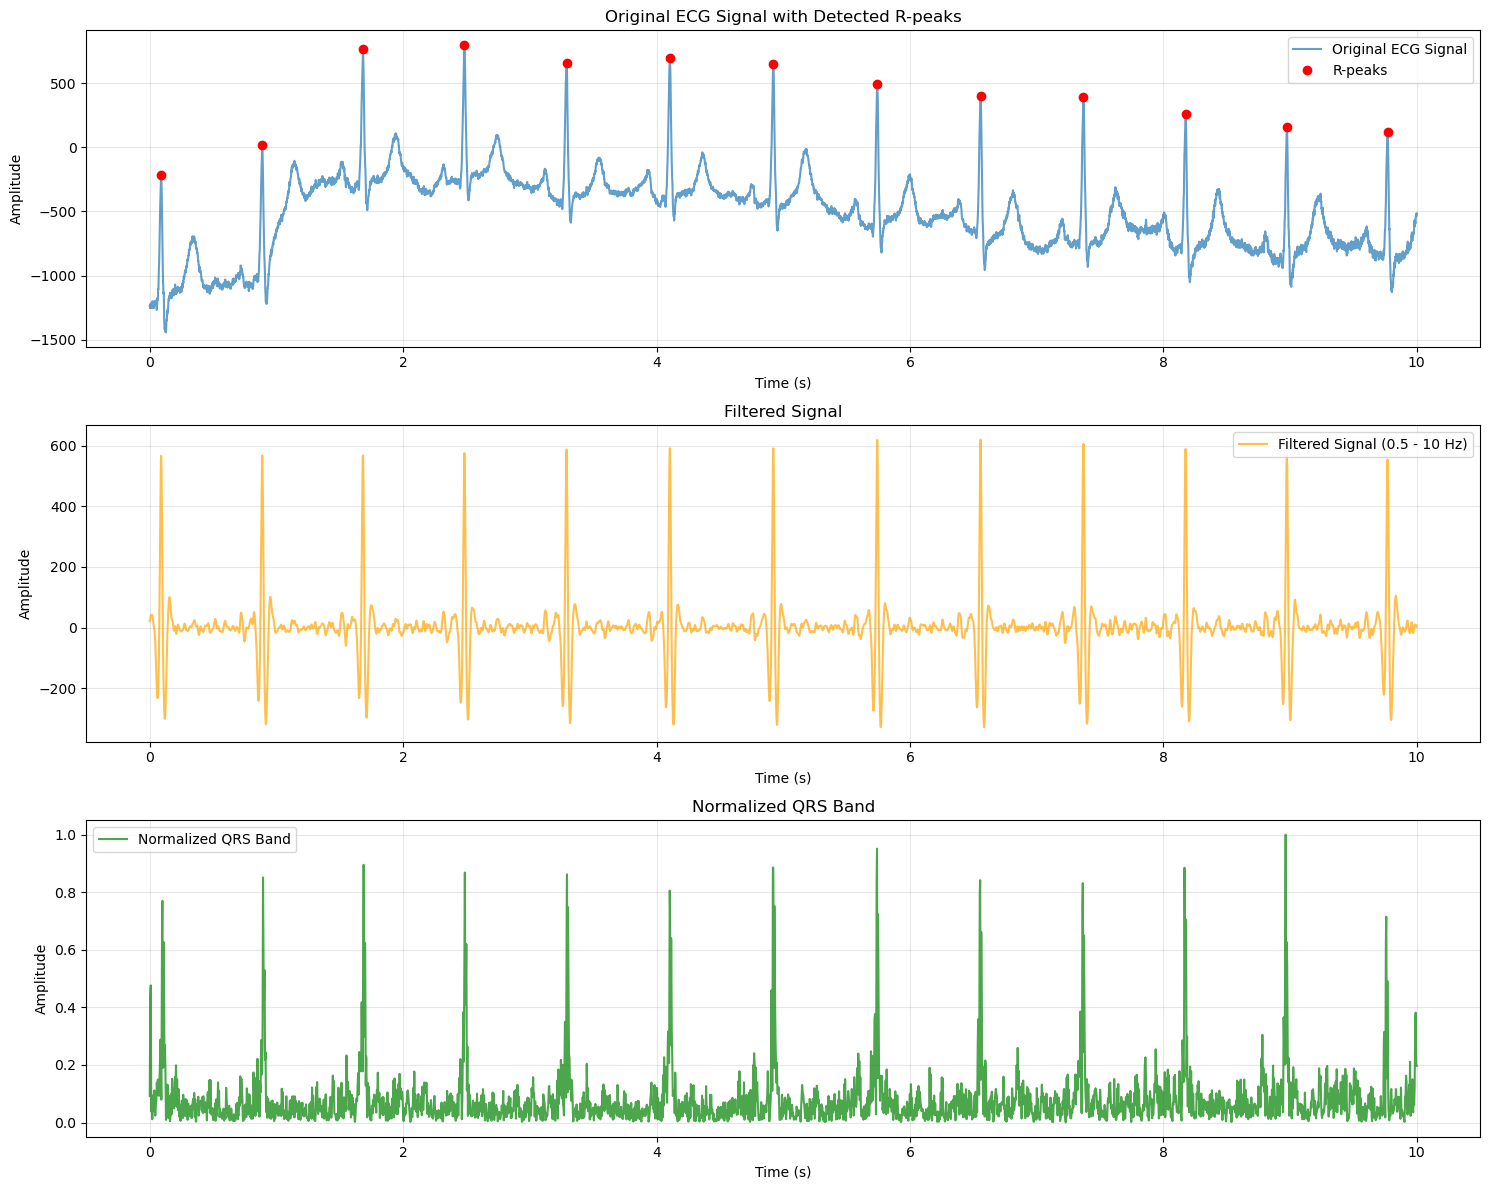

Detected R-peaks at indices: [  90  887 1683 2483 3290 4105 4922 5742 6558 7369 8176 8975 9771]


In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import loadmat

def bandpass_filter(signal, fs, low_cut=10, high_cut=50):
    """Apply a bandpass filter to the signal."""
    nyquist = fs / 2
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def detect_r_peaks(filtered_signal, original_signal, wavelet='sym4', level=3, fs=250):
    """Detect R-peaks using wavelet decomposition and refinement."""
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
    
    # Combine detail coefficients d2 and d3
    d2 = coeffs[2]
    d3 = coeffs[3]
    d3_upsampled = np.interp(np.linspace(0, len(d3), len(d2)),
                             np.arange(len(d3)),
                             d3)
    qrs_band = np.abs(d2) + np.abs(d3_upsampled)

    # Reconstruct signal from QRS band
    reconstructed_signal = np.interp(np.linspace(0, len(qrs_band), len(filtered_signal)),
                                      np.arange(len(qrs_band)),
                                      qrs_band)
    
    # Normalize the reconstructed signal
    normalized_signal = reconstructed_signal / np.max(reconstructed_signal)
    
    # Detect peaks in the normalized QRS band
    min_rr = int(0.6 * fs)  # Minimum R-R interval (600ms)
    min_height = 0.3        # Minimum peak height
    peaks, _ = find_peaks(normalized_signal, height=min_height, distance=min_rr)

    # Refine peaks to locate precise R positions on the original signal
    refined_peaks = []
    search_window = int(0.05 * fs)  # +/-50ms window for refinement
    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(original_signal), peak + search_window)
        refined_peak = start + np.argmax(original_signal[start:end])
        refined_peaks.append(refined_peak)

    return np.array(refined_peaks), filtered_signal, normalized_signal

def plot_results(original_signal, filtered_signal, normalized_signal, r_peaks, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 12))

    # Original ECG Signal
    plt.subplot(311)
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    plt.title('Original ECG Signal with Detected R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Filtered Signal
    plt.subplot(312)
    plt.plot(time, filtered_signal, label='Filtered Signal (0.5 - 10 Hz)', color='orange', alpha=0.7)
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Normalized QRS Band
    plt.subplot(313)
    plt.plot(time, normalized_signal, label='Normalized QRS Band', color='green', alpha=0.7)
    plt.title('Normalized QRS Band')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    # Load ECG data from a .mat file
    mat_data = loadmat('s0017lrem.mat')
    #mat_data = loadmat('08378m.mat')
    fs = 1000  # Sampling frequency
    ecg_signal = mat_data['val'][0].squeeze()

    # Preprocess signal: Bandpass filter (0.5 - 10 Hz)
    filtered_signal = bandpass_filter(ecg_signal, fs)

    # Detect R-peaks on the filtered signal
    r_peaks, filtered_signal, normalized_signal = detect_r_peaks(filtered_signal, ecg_signal, fs=fs)

    # Plot results
    plot_results(ecg_signal, filtered_signal, normalized_signal, r_peaks, fs)

    print("Detected R-peaks at indices:", r_peaks)

if __name__ == '__main__':
    main()


### testing

[  98  298  499  902 1101 1298 1497 1695 1894 2094 2298]
[97, 298, 499, 902, 1100, 1297, 1497, 1694, 1894, 2094, 2297]


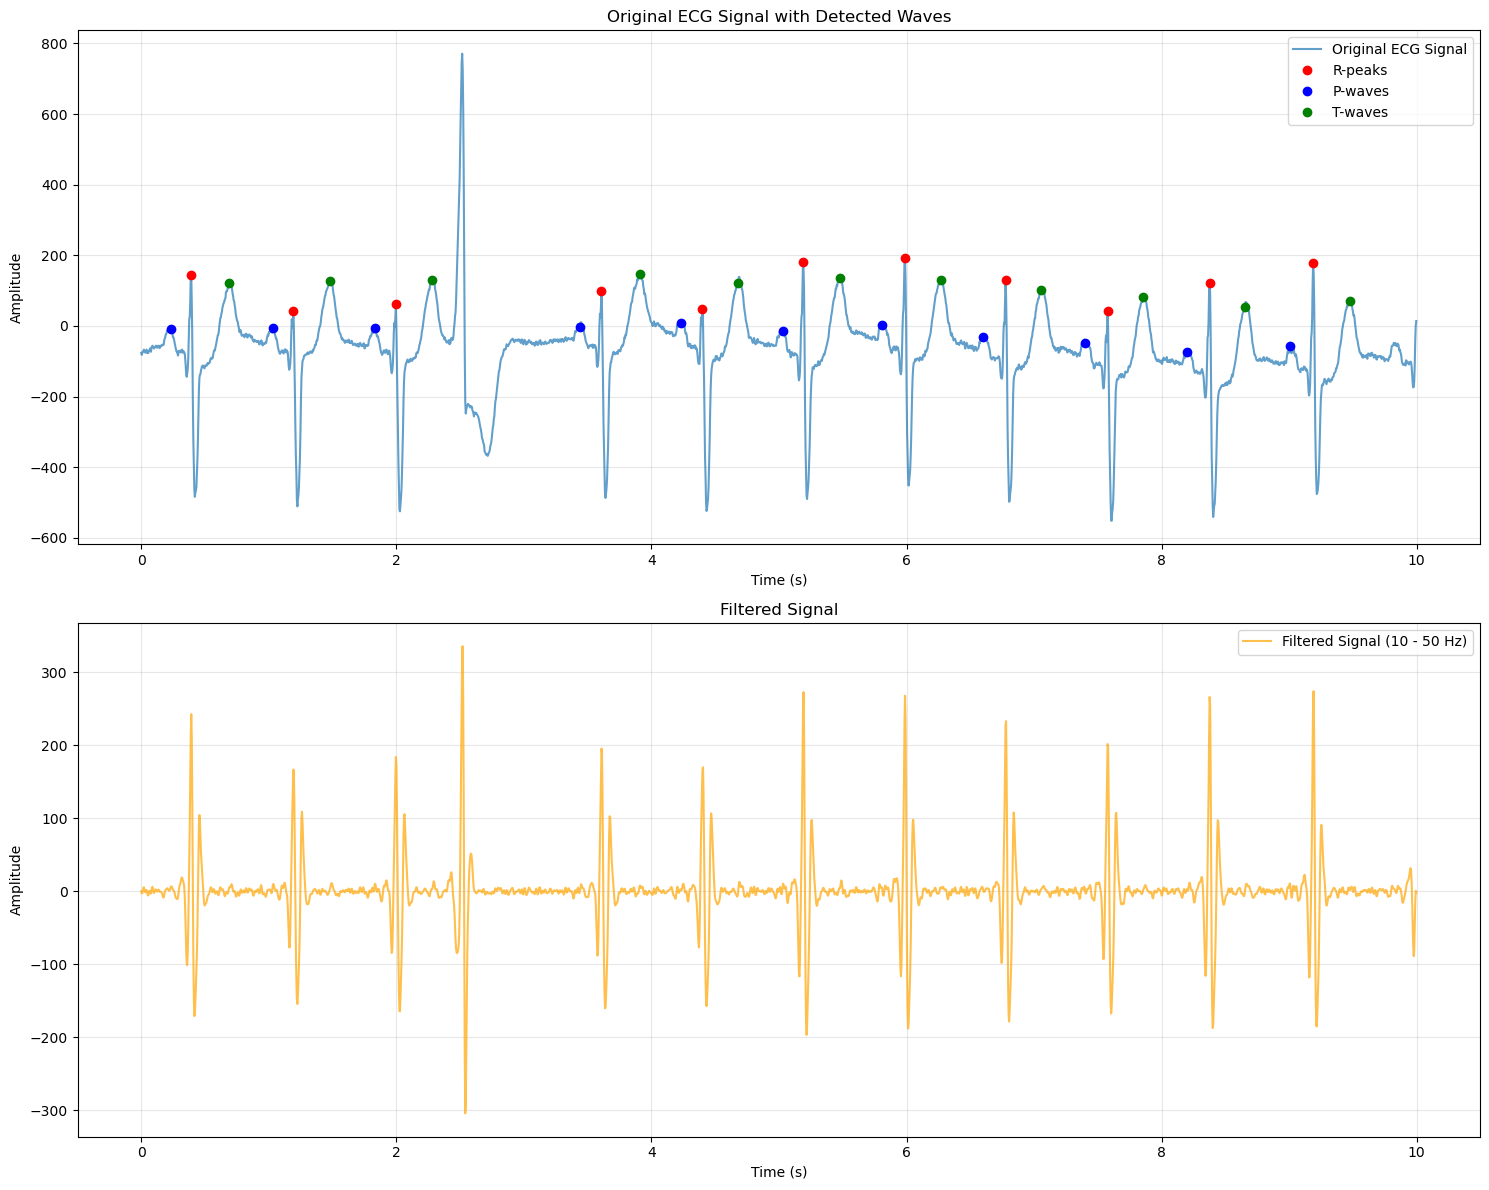

Detected R-peaks at indices: [  97  298  499  902 1100 1297 1497 1694 1894 2094 2297]
Detected P-wave locations: [  58  258  458  859 1058 1257 1452 1650 1850 2050 2251]
Detected T-wave locations: [ 172  370  570  978 1170 1369 1568 1763 1963 2163 2369]


In [18]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import loadmat

def bandpass_filter(signal, fs, low_cut=10, high_cut=50):
    """Apply a bandpass filter to the signal."""
    nyquist = fs / 2
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def detect_r_peaks(filtered_signal, original_signal, fs=250):
    """Detect R-peaks using wavelet decomposition and refinement."""  
    # Detect peaks in the QRS band
    min_rr = int(0.4 * fs)  # Minimum R-R interval (600ms)
    min_height = 110        # Minimum peak height
    max_height = 300
    peaks, _ = find_peaks(filtered_signal, height=(min_height, max_height), distance=min_rr)
    # Refine peaks to locate precise R positions on the original signal
    refined_peaks = []
    search_window = int(0.05 * fs)  # +/-50ms window for refinement
    for peak in peaks:
        start = max(0, peak - search_window)
        end = min(len(original_signal), peak + search_window)
        refined_peak = start + np.argmax(original_signal[start:end])
        refined_peaks.append(refined_peak)
    print(peaks)
    print(refined_peaks)
    return np.array(refined_peaks), filtered_signal

def detect_p_t_waves(signal, qrs_locs, fs):
    p_waves = []
    t_waves = []
    
    # Wavelet decomposition optimized for P and T waves
    coeffs = pywt.wavedec(signal, 'sym4', level=3)
    low_freq_signal = pywt.waverec([coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]], wavelet="sym4")
    # Use approximation coefficients for smoother signal
    smooth_signal = low_freq_signal
    smooth_signal = np.interp(np.linspace(0, len(smooth_signal), len(signal)), 
                            np.arange(len(smooth_signal)), 
                            smooth_signal)
    
    # Time windows based on physiology
    pr_interval = int(0.2 * fs)  # 200ms
    pr_min = int(0.12 * fs)      # 120ms
    qt_interval = int(0.42 * fs)  # 420ms
    qt_min = int(0.2 * fs)       # 200ms
    
    for qrs in qrs_locs:
        # P wave detection
        p_start = max(0, qrs - pr_interval)
        p_end = max(0, qrs - pr_min)
        
        if p_start < p_end:
            p_window = smooth_signal[p_start:p_end]
            if len(p_window) > 0:
                # Find local maxima in P wave window
                p_peaks, _ = find_peaks(p_window, distance=int(0.1 * fs))
                if len(p_peaks) > 0:
                    p_loc = p_start + p_peaks[np.argmax(p_window[p_peaks])]
                    if p_loc not in p_waves:
                        p_waves.append(p_loc)
        
        # T wave detection
        t_start = min(len(signal)-1, qrs + qt_min)
        t_end = min(len(signal)-1, qrs + qt_interval)
        
        if t_start < t_end:
            t_window = smooth_signal[t_start:t_end]
            if len(t_window) > 0:
                # Find local maxima in T wave window
                t_peaks, _ = find_peaks(t_window, distance=int(0.1 * fs))
                if len(t_peaks) > 0:
                    t_loc = t_start + t_peaks[np.argmax(t_window[t_peaks])]
                    if t_loc not in t_waves:
                        t_waves.append(t_loc)
    
    return np.array(p_waves), np.array(t_waves)

def plot_results(original_signal, filtered_signal, r_peaks, p_waves, t_waves, fs):
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(15, 12))

    # Original ECG Signal with R-peaks, P-waves, and T-waves
    plt.subplot(211)
    plt.plot(time, original_signal, label='Original ECG Signal', alpha=0.7)
    plt.plot(r_peaks / fs, original_signal[r_peaks], 'ro', label='R-peaks', markersize=6)
    plt.plot(p_waves / fs, original_signal[p_waves], 'bo', label='P-waves', markersize=6)
    plt.plot(t_waves / fs, original_signal[t_waves], 'go', label='T-waves', markersize=6)
    plt.title('Original ECG Signal with Detected Waves')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Filtered Signal
    plt.subplot(212)
    plt.plot(time, filtered_signal, label='Filtered Signal (10 - 50 Hz)', color='orange', alpha=0.7)
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

def main():
    # Load ECG data from a .mat file
    mat_data = loadmat('08378m.mat')
    fs = 250 # Sampling frequency
    ecg_signal = mat_data['val'][0].squeeze()

    # Preprocess signal: Bandpass filter (10 - 50 Hz)
    filtered_signal = bandpass_filter(ecg_signal, fs)

    # Detect R-peaks on the filtered signal
    r_peaks, filtered_signal = detect_r_peaks(filtered_signal, ecg_signal, fs=fs)

    # Detect P and T waves using R-peak locations
    p_waves, t_waves = detect_p_t_waves(ecg_signal, r_peaks, fs)

    # Plot results
    plot_results(ecg_signal, filtered_signal, r_peaks, p_waves, t_waves, fs)

    print("Detected R-peaks at indices:", r_peaks)
    print("Detected P-wave locations:", p_waves)
    print("Detected T-wave locations:", t_waves)

if __name__ == '__main__':
    main()

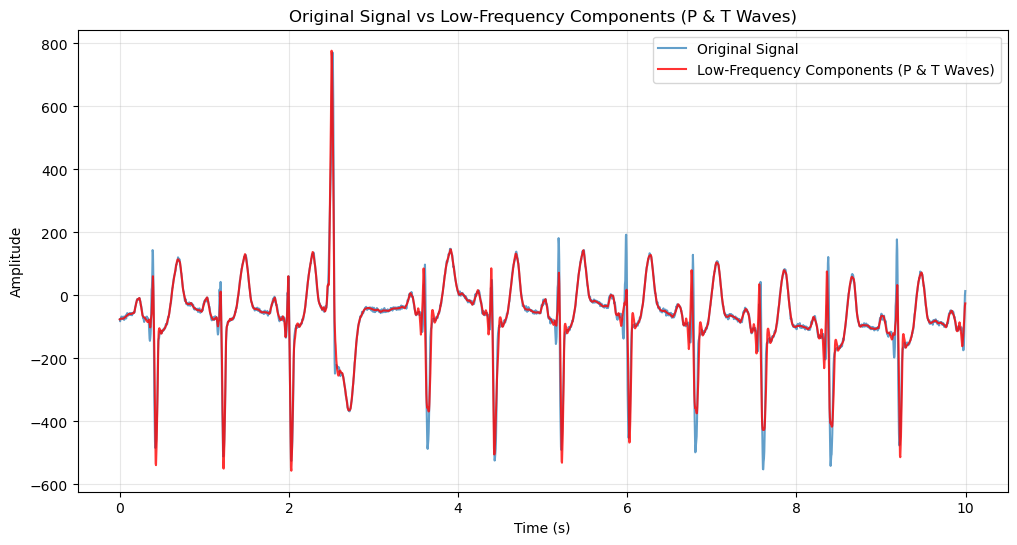

In [28]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def extract_low_frequency_components(signal, wavelet='sym4', level=1):
    """
    Extract low-frequency components of the signal using wavelet decomposition.
    This corresponds to the P and T waves in an ECG signal.
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Keep only the approximation coefficients (low-frequency components)
    low_freq_signal = pywt.waverec([coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)
    
    return low_freq_signal

def plot_extracted_waves(original_signal, extracted_signal, fs):
    """
    Plot the original ECG signal and the extracted low-frequency components.
    """
    time = np.arange(len(original_signal)) / fs  # Time in seconds

    plt.figure(figsize=(12, 6))
    plt.plot(time, original_signal, label='Original Signal', alpha=0.7)
    plt.plot(time, extracted_signal, label='Low-Frequency Components (P & T Waves)', color='red', alpha=0.8)
    plt.title('Original Signal vs Low-Frequency Components (P & T Waves)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def main():
    # Example signal: Replace this with your ECG data loading step
    from scipy.io import loadmat
    mat_data = loadmat('08378m.mat')  # Load your ECG data file
    fs = 250  # Sampling frequency
    ecg_signal = mat_data['val'][0].squeeze()  # Extract signal from .mat file

    # Extract low-frequency components (P and T waves)
    low_freq_signal = extract_low_frequency_components(ecg_signal, wavelet='sym4', level=3)

    # Plot the original signal and the extracted low-frequency components
    plot_extracted_waves(ecg_signal, low_freq_signal, fs)

if __name__ == '__main__':
    main()
